# Failures

Failure cause hosts to stop periodically. In OpenDC, failures can be simulated by providing a trace. 
This trace describes when failures occur, how long they are, and how intens (how many hosts are effected). 

In this demo, we will investigate the effect of failures.

#### Lets start by looking at one of the failure traces.

In [1]:
import pandas as pd

df_failure = pd.read_parquet("failure_traces/Facebook_user_reported.parquet")

df_failure

,failure_interval,failure_duration,failure_intensity
0,0,14400000,1.000000
1,1200000,19200000,1.000000
2,1200000,6000000,0.666667
3,1200000,6000000,1.000000
4,1200000,1200000,0.833333
...,...,...,...
4064,13200000,1200000,0.500000
4065,194400000,2400000,1.000000
4066,280800000,1200000,0.666667
4067,332400000,2400000,0.833333


## Experiment

Failures can be added to the simulation using the experiment file. 
First, we will run a workload with, and without failures. 

For this we need to run two simulations, one using an experiment file similar to the one used in the previous demo. You can find the file [here](experiments/2.no_failures.json)

Next, we make an experiment with failures. To do this we need to add a "failureModel" to the experiment file. 
This results in the experiment file that can be found [here](experiments/2.Facebook_failures.json), and is shown below:

```json
{
    "name": "Facebook_failures",
    "outputFolder": "output/2.failures",
    "topologies": [
        {
            "pathToFile": "topologies/2.demo_failures/surfsara_small.json"
        }
    ],
    "workloads": [
        {
            "pathToFile": "workload_traces/2022-10-01_2022-10-02",
            "type": "ComputeWorkload"
        }
    ],
    "exportModels": [
        {
            "exportInterval": 300
        }
    ],
    "failureModels": [
        {
            "type": "trace-based",
            "pathToFile": "failure_traces/Facebook_user_reported.parquet"
        }
    ]
}
```

This experiment adds the Facebook_user_reported failure trace to the simulation. 

#### Lets run both experiments

In [2]:
import subprocess

pathToScenario = "experiments/2.Facebook_failures.json"
subprocess.run(["OpenDCExperimentRunner/bin/OpenDCExperimentRunner", "--experiment-path", pathToScenario])



 Running scenario: 0 
 Starting seed: 0 


Simulating...   0% [                                       ] 0/2 (0:00:00 / ?) 

12:39:20.508 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 2 hours:
						Tasks Total: 44
						Tasks Active: 42
						Tasks Pending: 0
						Tasks Completed: 2
						Tasks Terminated: 0

12:39:20.531 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 4 hours:
						Tasks Total: 44
						Tasks Active: 42
						Tasks Pending: 0
						Tasks Completed: 2
						Tasks Terminated: 0

12:39:20.549 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 6 hours:
						Tasks Total: 44
						Tasks Active: 39
						Tasks Pending: 0
						Tasks Completed: 5
						Tasks Terminated: 0

12:39:20.566 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 8 hours:
						Tasks Total: 45
						Tasks Active: 39
						Tasks Pending: 0
						Tasks Completed: 6
						Tasks Terminated: 0

12:39:20.616 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricRea

Simulating... 100% [=================================] 2/2 (0:00:01 / 0:00:00) 


CompletedProcess(args=['OpenDCExperimentRunner/bin/OpenDCExperimentRunner', '--experiment-path', 'experiments/2.Facebook_failures.json'], returncode=0)

## Analysis

We can see that many tasks did not succeed.
When a tasks fails too many times, the task gets terminated from the system.
Lets further investigate the failures 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_host = pd.read_parquet("output/2.failures/Facebook_failures/raw-output/0/seed=0/host.parquet")
df_power = pd.read_parquet("output/2.failures/Facebook_failures/raw-output/0/seed=0/powerSource.parquet")
df_task = pd.read_parquet("output/2.failures/Facebook_failures/raw-output/0/seed=0/task.parquet")
df_service = pd.read_parquet("output/2.failures/Facebook_failures/raw-output/0/seed=0/service.parquet")

df_host_fail = pd.read_parquet("output/2.failures/Facebook_failures/raw-output/1/seed=0/host.parquet")
df_power_fail = pd.read_parquet("output/2.failures/Facebook_failures/raw-output/1/seed=0/powerSource.parquet")
df_task_fail = pd.read_parquet("output/2.failures/Facebook_failures/raw-output/1/seed=0/task.parquet")
df_service_fail = pd.read_parquet("output/2.failures/Facebook_failures/raw-output/1/seed=0/service.parquet")

In [4]:
tasks_terminated = df_service.iloc[-1].tasks_terminated
tasks_terminated_fail = df_service_fail.iloc[-1].tasks_terminated

print(f"In the normal simulation {tasks_terminated} tasks were terminated")
print(f"When adding failures {tasks_terminated_fail} tasks were terminated")

In the normal simulation 0 tasks were terminated
When adding failures 37 tasks were terminated


#### Lets compare the runtimes

In [5]:
runtime = pd.to_timedelta(df_service.timestamp.max() - df_service.timestamp.min(), unit="ms")
runtime_fail = pd.to_timedelta(df_service_fail.timestamp.max() - df_service_fail.timestamp.min(), unit="ms")

print(f"The workload took {runtime} without failures")
print(f"The workload took {runtime_fail} with failures")


The workload took 1 days 00:01:43 without failures
The workload took 2 days 22:15:00 with failures


##### Adding failures almost tripled the runtime!

## Visualization

We can plot the active tasks over time to see what is happening

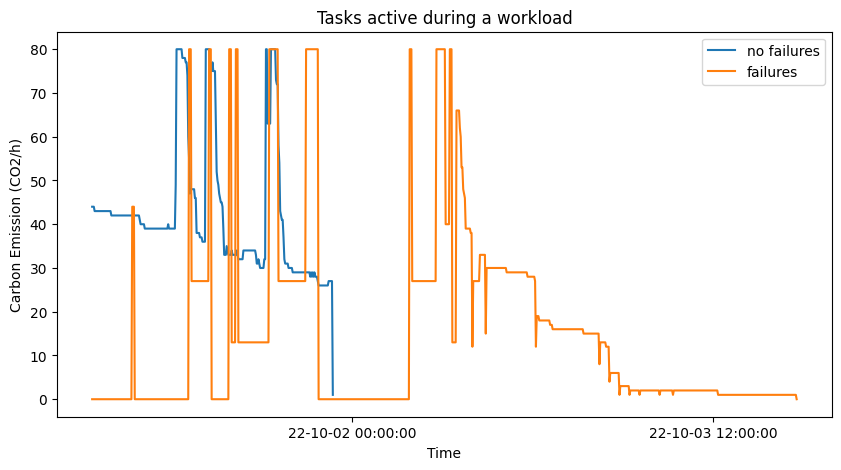

In [6]:
import matplotlib.dates as mdates

timestamps = pd.to_datetime(df_service[:-1].timestamp_absolute, unit="ms")
timestamps_failures = pd.to_datetime(df_service_fail[:-1].timestamp_absolute, unit="ms")


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(timestamps, df_service[:-1].tasks_active, label="no failures")
ax.plot(timestamps_failures, df_service_fail[:-1].tasks_active, label="failures")

plt.title("Tasks active during a workload")
plt.xlabel("Time")
plt.ylabel("Carbon Emission (CO2/h)")
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
myFmt = mdates.DateFormatter('%y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)

plt.legend()
plt.show()

#### We can clearly see that the failures are creating idle periods

## Comparing Failure traces

In the failure_traces folder we find five failure traces gathered from different applications. 
Lets compare the effect of the different failure traces on the same workload. 
To do this, we have created a new experiment which you can find [here](experiments/2.all_failures.json).
Its content is shown below:

```json
{
    "name": "all_failures",
    "outputFolder": "output/2.failures",
    "topologies": [
        {
            "pathToFile": "topologies/2.demo_failures/surfsara_small.json"
        }
    ],
    "workloads": [
        {
            "pathToFile": "workload_traces/2022-10-01_2022-10-02",
            "type": "ComputeWorkload"
        }
    ],
    "exportModels": [
        {
            "exportInterval": 300
        }
    ],
    "failureModels": [
        {
            "type": "trace-based",
            "pathToFile": "failure_traces/Facebook_user_reported.parquet"
        },
        {
            "type": "trace-based",
            "pathToFile": "failure_traces/Instagram_user_reported.parquet"
        },
        {
            "type": "trace-based",
            "pathToFile": "failure_traces/Netflix_user_reported.parquet"
        },
        {
            "type": "trace-based",
            "pathToFile": "failure_traces/Whatsapp_user_reported.parquet"
        },
        {
            "type": "trace-based",
            "pathToFile": "failure_traces/YouTube_user_reported.parquet"
        }
    ]
}
```

Using a list of different failure traces instructs OpenDC to run multiple simulation, all with a different failure trace.

In [7]:
import subprocess

pathToScenario = "experiments/2.all_failures.json"
subprocess.run(["OpenDCExperimentRunner/bin/OpenDCExperimentRunner", "--experiment-path", pathToScenario])




 Running scenario: 0 
 Starting seed: 0 


Simulating...   0% [                                       ] 0/5 (0:00:00 / ?) 

12:39:23.354 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 2 hours:
						Tasks Total: 44
						Tasks Active: 0
						Tasks Pending: 44
						Tasks Completed: 0
						Tasks Terminated: 0

12:39:23.365 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 4 hours:
						Tasks Total: 44
						Tasks Active: 0
						Tasks Pending: 44
						Tasks Completed: 0
						Tasks Terminated: 0

12:39:23.409 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 6 hours:
						Tasks Total: 44
						Tasks Active: 0
						Tasks Pending: 43
						Tasks Completed: 1
						Tasks Terminated: 0

12:39:23.416 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 8 hours:
						Tasks Total: 45
						Tasks Active: 0
						Tasks Pending: 44
						Tasks Completed: 1
						Tasks Terminated: 0

12:39:23.470 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricRea

Simulating...  40% [=============                    ] 2/5 (0:00:02 / 0:00:03) 



 Running scenario: 3 
 Starting seed: 0 
12:39:24.813 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 2 hours:
						Tasks Total: 44
						Tasks Active: 0
						Tasks Pending: 44
						Tasks Completed: 0
						Tasks Terminated: 0

12:39:24.815 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 4 hours:
						Tasks Total: 44
						Tasks Active: 0
						Tasks Pending: 44
						Tasks Completed: 0
						Tasks Terminated: 0

12:39:24.824 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 6 hours:
						Tasks Total: 44
						Tasks Active: 19
						Tasks Pending: 24
						Tasks Completed: 1
						Tasks Terminated: 0

12:39:24.831 [WARN ] org.opendc.compute.simulator.telemetry.ComputeMetricReader - 
					Metrics after 8 hours:
						Tasks Total: 45
						Tasks Active: 40
						Tasks Pending: 2
						Tasks Completed: 3
						Tasks Terminated: 0

12:39:24.841 [WARN ] org.opendc.

Simulating... 100% [=================================] 5/5 (0:00:02 / 0:00:00) 


CompletedProcess(args=['OpenDCExperimentRunner/bin/OpenDCExperimentRunner', '--experiment-path', 'experiments/2.all_failures.json'], returncode=0)

## Visualization

Lets load the output data, and compare the results

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df_host_facebook = pd.read_parquet("output/2.failures/all_failures/raw-output/0/seed=0/host.parquet")
df_power_facebook = pd.read_parquet("output/2.failures/all_failures/raw-output/0/seed=0/powerSource.parquet")
df_service_facebook = pd.read_parquet("output/2.failures/all_failures/raw-output/0/seed=0/service.parquet")
df_task_facebook = pd.read_parquet("output/2.failures/all_failures/raw-output/0/seed=0/task.parquet")

df_host_instagram = pd.read_parquet("output/2.failures/all_failures/raw-output/1/seed=0/host.parquet")
df_power_instagram = pd.read_parquet("output/2.failures/all_failures/raw-output/1/seed=0/powerSource.parquet")
df_service_instagram = pd.read_parquet("output/2.failures/all_failures/raw-output/1/seed=0/service.parquet")
df_task_instagram = pd.read_parquet("output/2.failures/all_failures/raw-output/1/seed=0/task.parquet")

df_host_netflix = pd.read_parquet("output/2.failures/all_failures/raw-output/2/seed=0/host.parquet")
df_power_netflix = pd.read_parquet("output/2.failures/all_failures/raw-output/2/seed=0/powerSource.parquet")
df_service_netflix = pd.read_parquet("output/2.failures/all_failures/raw-output/2/seed=0/service.parquet")
df_task_netflix = pd.read_parquet("output/2.failures/all_failures/raw-output/2/seed=0/task.parquet")

df_host_whatsapp = pd.read_parquet("output/2.failures/all_failures/raw-output/3/seed=0/host.parquet")
df_power_whatsapp = pd.read_parquet("output/2.failures/all_failures/raw-output/3/seed=0/powerSource.parquet")
df_service_whatsapp = pd.read_parquet("output/2.failures/all_failures/raw-output/3/seed=0/service.parquet")
df_task_whatsapp = pd.read_parquet("output/2.failures/all_failures/raw-output/3/seed=0/task.parquet")

df_host_youtube = pd.read_parquet("output/2.failures/all_failures/raw-output/4/seed=0/host.parquet")
df_power_youtube = pd.read_parquet("output/2.failures/all_failures/raw-output/4/seed=0/powerSource.parquet")
df_service_youtube = pd.read_parquet("output/2.failures/all_failures/raw-output/4/seed=0/service.parquet")
df_task_youtube = pd.read_parquet("output/2.failures/all_failures/raw-output/4/seed=0/task.parquet")

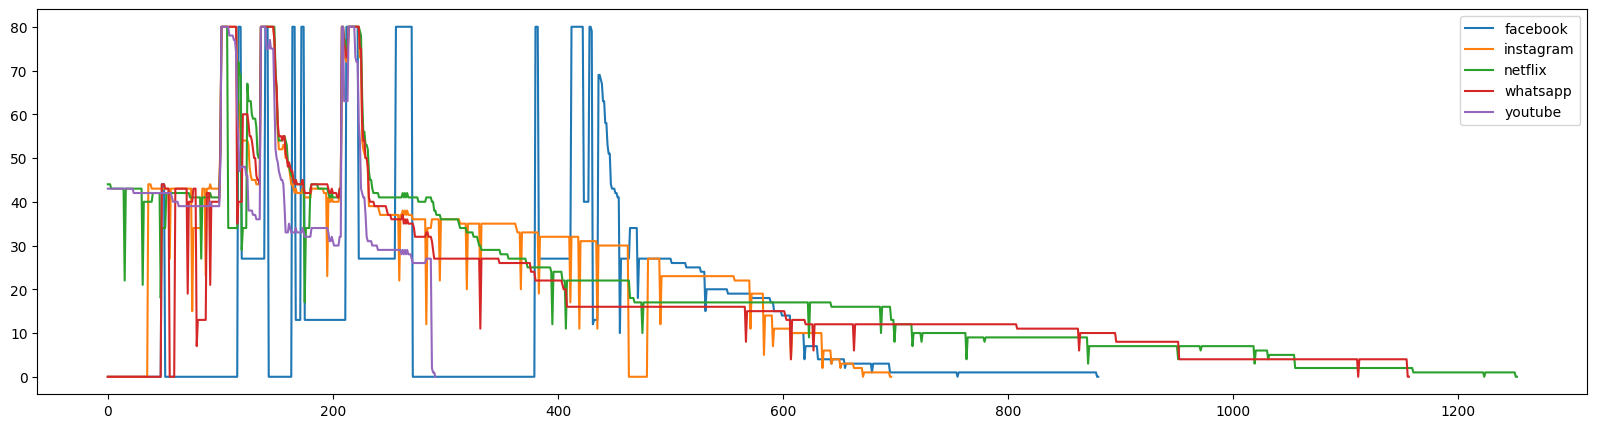

In [9]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df_service_facebook.tasks_active, label="facebook")
ax.plot(df_service_instagram.tasks_active, label="instagram")
ax.plot(df_service_netflix.tasks_active, label="netflix")
ax.plot(df_service_whatsapp.tasks_active, label="whatsapp")
ax.plot(df_service_youtube.tasks_active, label="youtube")

ax.legend()

plt.show()


#### We can see a clear difference between when the failures occur, their intensity, and the overall effect of the failures.